# Instructions

This notebook accompanies the final takehome exam.

* Sections that you need to change to receive full credit are surounded with comments like this:
    
```python
############################################
# THIS SIGNALS CODE THAT YOU HAVE TO CHANGE
############################################
```

* You are expected to do all of the calculations for the exam by hand and only check your work using this notebook and use this notebook for plotting.

## Submission

To turn this exam in, print out your final notebook using file print (within google colab), or file export to html, print (if using ipython on your computer), and attach it to your handwritten work for the exam. The exam should be submitted in a similar format as homework assignments.

# Functions

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
def power_spectrum(t, d, fmin=0, fmax=30, width=0.5, n=8):
    T = t[-1] - t[0]
    ak = np.fft.ifft(d);
    dt = T/len(d)
    k = np.arange(0, len(d)//n)
    freq = k/T
    plt.bar(freq, np.abs(ak[k]), width=width)
    plt.ylabel('|ak|')
    plt.xlabel('Hz')
    plt.grid()
    ax = plt.gca().set_xlim(fmin, fmax)
    return ak, freq

# Simulation Code

In [3]:
def simulate_spacecraft_docking(design_data):
    """
    @param G: The Laplace transform of X/T, x position over thrust
    @param H: Your controller with noise filter.
    """
    G = design_data['G']
    H = design_data['H']
    Ge_r = design_data['Ge_r']
    Ge_n = design_data['Ge_n']
    Ge_d = design_data['Ge_d']
    noise = design_data['noise']
    disturbance = design_data['disturbance']
    t = noise[:, 0]
    reference = 1 + 0.2*t + 0.1*t**2  # the reference trajectory

    # compute output
    e_r = control.forced_response(Ge_r, U=reference, T=t)[1];
    e_n = control.forced_response(Ge_n, U=noise[:, 1], T=t)[1];
    e_d = control.forced_response(Ge_d, U=disturbance[:, 1], T=t)[1];
    e = e_r + e_n + e_d
        
    vx = 1
    t1 = t[-1]
    t0 = t1 - 2
    
    i0 = np.argmax(t > t0)
    
    x0 = vx*t0
    x1 = vx*t1
    
    error_tol = 0.1
    plt.figure(figsize=(10, 5))
    plt.plot(t, e)
    plt.plot(x1, 0, 's', markersize=10, label='space station')
    plt.hlines(error_tol, x0, x1, label='docking window', linewidth=3)
    plt.hlines(-error_tol, x0, x1, linewidth=3)
    plt.grid()
    plt.legend()
    plt.axis('equal')
    plt.xlabel('x error, m')
    plt.ylabel('y error, m')

    if np.any(np.abs(e[i0:]) > error_tol):
        print('CRASH')
    else:
        print('SUCCESSFUL DOCKING')
        
    return locals()

# Design Code

CRASH


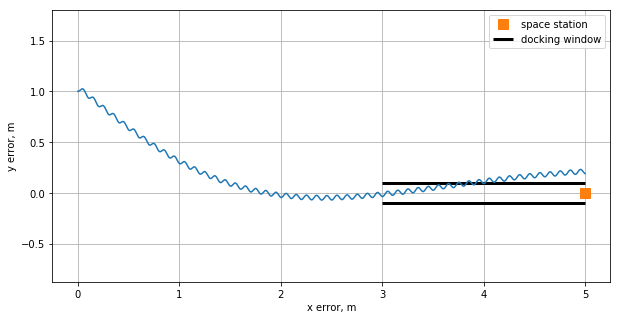

In [4]:
import control
import scipy.signal
from numpy import genfromtxt

def design():
    
    # load data for noise and disturbance for analysis
    noise = np.loadtxt('data/final_s19_noise.csv', delimiter=',')
    disturbance = np.loadtxt('data/final_s19_disturbance.csv', delimiter=',')

    # constants
    m = 1
    s = control.tf([1, 0], [0, 1])
    G = 1/(m*s**2)

    #########################################
    # ONLY CHANGE K, p, based on your design
    K = 1
    p = 10*2*np.pi

    #########################################
    H_noise_filter = p/(s + p) #control.tf(*scipy.signal.butter(N=2, Wn=Wn, analog=True))
    H_controller = K*(s + 1)
    H = H_controller*H_noise_filter

    # find transfer functions for error, e
    Ge_r = control.minreal(1/(1+G*H), verbose=False)
    Ge_n = control.minreal(G*H/(1+G*H), verbose=False)
    Ge_d = control.minreal(-G/(1+G*H), verbose=False)
    
    return locals()

design_data = design()
sim_data = simulate_spacecraft_docking(design_data);

# Noise Filtering Tuning

Design a noise filter that attenuates your lowest noise frequency by 20 dB.

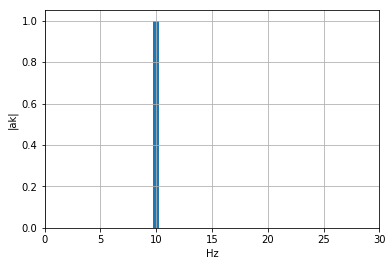

In [5]:
power_spectrum(design_data['noise'][:, 0], design_data['noise'][:, 1]);

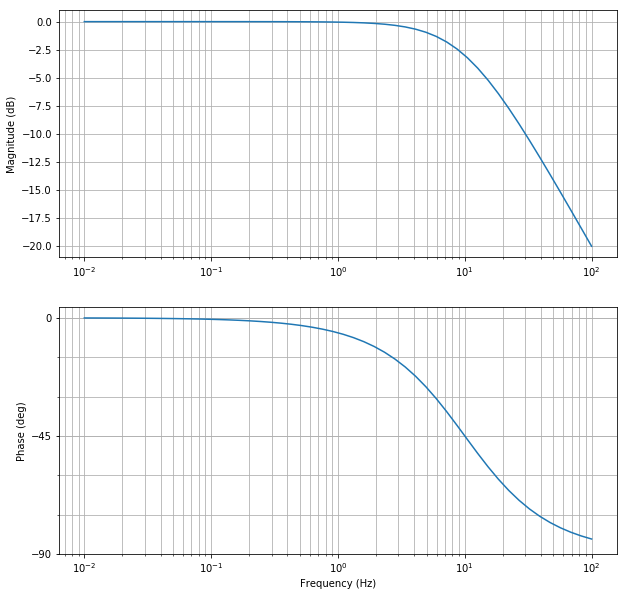

In [6]:
s = control.tf([1, 0], [0, 1])
p = design_data['p']
plt.figure(figsize=(10, 10))
control.bode(p/(s+p), omega=2*np.pi*np.logspace(-2, 2), Hz=True, dB=True);

# Error Analysis

Set the controller gain such that the steady state error is 4 cm.

## Reference Tracking Error

$r(t) = 0.1 + 0.2t + 0.1t^2$

In [7]:
Ge_r = design_data['Ge_r']
s = control.tf([1, 0], [0, 1])

#######################################################################
# Set the Laplace transform of your input here
# example: r_s = 1/s
r_s = 0  # laplace transform of reference input

#######################################################################
e_r_ss = np.abs(control.minreal(Ge_r*s*r_s, verbose=False)(0))
print("steady state error from reference trajectory: {:0.4g} cm".format(100*e_r_ss))

steady state error from reference trajectory: 0 cm


This bode plots is not necessary for this analysis, but shown below for those interested.

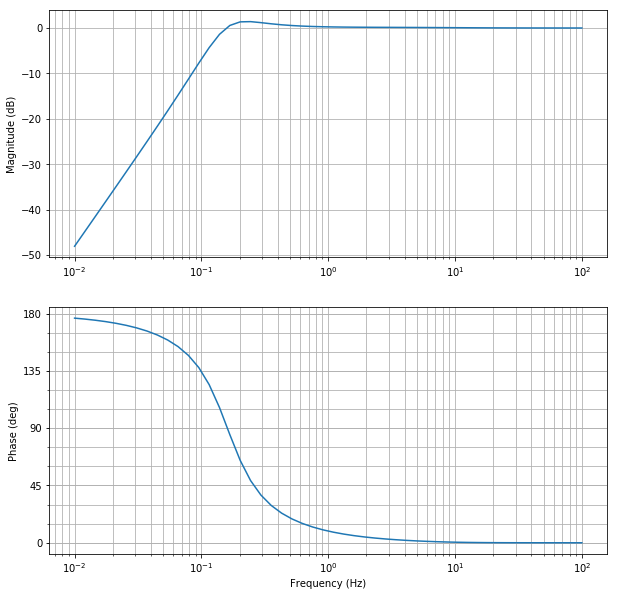

In [8]:
plt.figure(figsize=(10, 10))
control.bode(design_data['Ge_r'], dB=True, Hz=True);

# Noise

Now compute the noise that is transmitted to the error in the system. Since we know K and $\omega$.

The power spectrum is again helpful to look at.

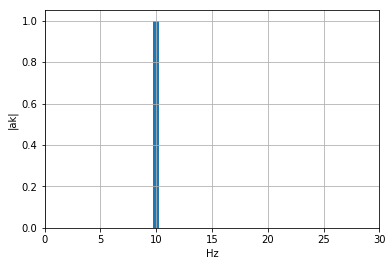

In [9]:
power_spectrum(design_data['noise'][:, 0], design_data['noise'][:, 1]);

In [10]:
Ge_n = design_data['Ge_n']

#######################################################################
# Use the power spectrum to predict the steady state error amplitude due
# to noise, given the transfer function Ge_n
# example: e_n_ss_amp = 4*np.abs(Ge_n(5*2*np.pi*1j))
e_n_ss_amp = 0
#######################################################################


print("steady state noise amplitude in output: {:0.4g} cm".format(100*e_n_ss_amp))

steady state noise amplitude in output: 0 cm


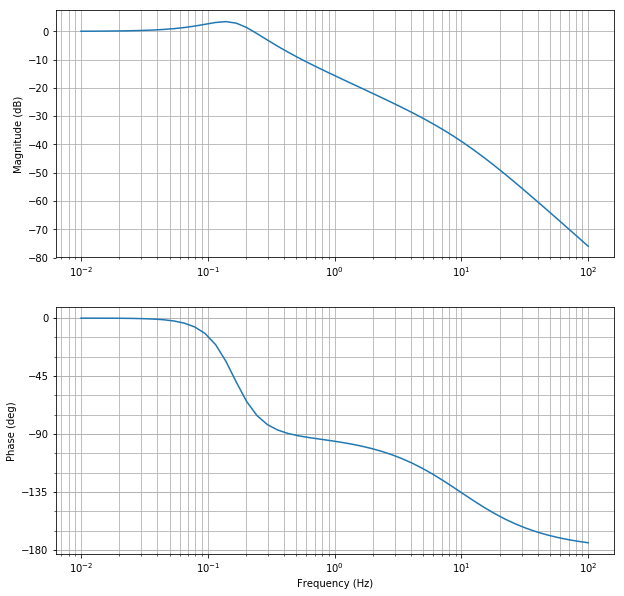

In [11]:
plt.figure(figsize=(10, 10))
plt.hlines(sim_data['error_tol'], sim_data['t'][0], sim_data['t'][-1], colors='r')
plt.hlines(-sim_data['error_tol'], sim_data['t'][0], sim_data['t'][-1], color='r')
control.bode(design_data['Ge_n'], dB=True, Hz=True);

## Disturbance

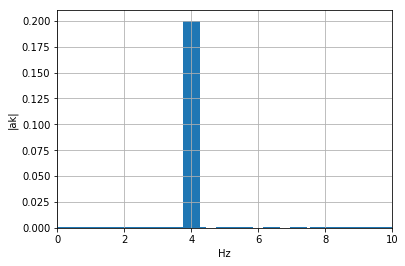

In [12]:
power_spectrum(design_data['disturbance'][:, 0], design_data['disturbance'][:, 1], fmax=10);

In [13]:
Ge_d = design_data['Ge_d']

#######################################################################
# Use the power spectrum to predict the steady state error amplitude due
# to disturbance, given the transfer function Ge_d
# example: e_d_ss_amp = 4*np.abs(Ge_d(5*2*np.pi*1j))
e_d_ss_amp = 0
#######################################################################

print("steady state disturbance amplitude in output: {:0.4g} cm".format(100*e_d_ss_amp))

steady state disturbance amplitude in output: 0 cm


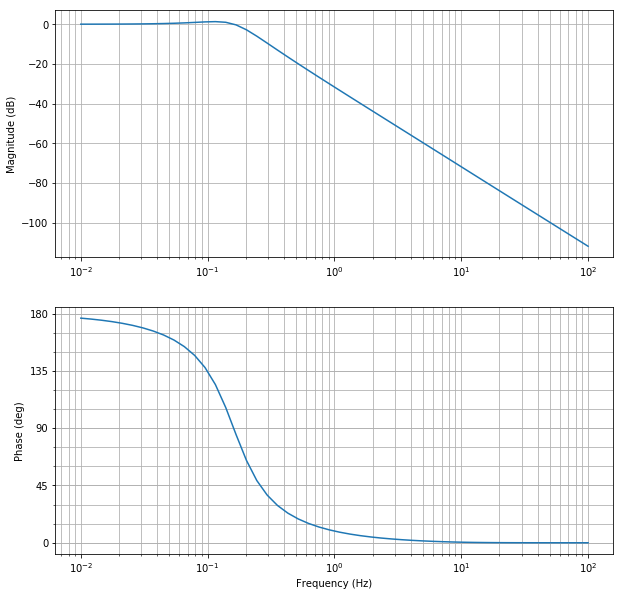

In [14]:
plt.figure(figsize=(10, 10))
control.bode(design_data['Ge_d'], dB=True, Hz=True);

## Steady State Total Error Bound

total error: 0 cm, docking tolerance 10 cm
theory predicts successful docking


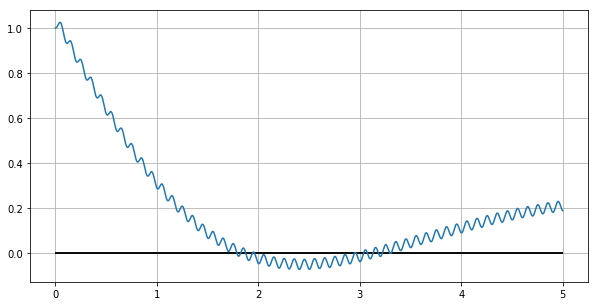

In [15]:
e_total = e_r_ss + e_n_ss_amp + e_d_ss_amp
e_tol = sim_data['error_tol']
print("total error: {:0.4g} cm, docking tolerance {:0.4g} cm".format(100*e_total, 100*e_tol))
if e_total < e_tol:
    print('theory predicts successful docking')
else:
    print('theory predicts crash')
    
plt.figure(figsize=(10, 5))
plt.plot(sim_data['t'], sim_data['e'])
plt.hlines(e_total, sim_data['t'][0], sim_data['t'][-1])
plt.hlines(-e_total, sim_data['t'][0], sim_data['t'][-1])
plt.grid()